# Segmentation of RGB and Multispectral Satellite Images
In recent years advances in deep learning have produced state-of-the-art results in Academia, and have begun to revolutionize industries. The combination of compute resources and big data with deep learning models often produces useful and interesting applications, several of which were not possible a few years ago. In this post, we’ll be covering one such application: the use of satellite images in combination with Computer Vision (CV). This post will serve as an example of how to build a specific model, but the technique used in this post could be extended to monitor crops, to detect forest fires, or even to assess the health of underwater flora.  

Traditionally an expensive asset, various low-cost sources of satellite data are now available for use by machine learning enthusiasts, including an open-dataset based on the Sentinel-2 cluster. In this blog post we provide a practical example on how to train a deep learning model which identifies tulip fields in satellite images. It does so on a per-pixel basis (i.e., each pixel is classified as belonging to a tulip field or not), which in the field of CV is referred to as segmentation. 

Machine learning models in general, and deep learning models in particular, learn by example. We will train our model by feeding it many examples of satellite images along with data about which parts of these images belong to tulip fields (this is usually referred to as ground truth). Once it has seen a sufficient amount of training examples, our system will be smart enough to be able to identify tulips in images it has never seen before.


## Data
We use images from the Sentinel-2 satellites, a mission operated by the European Space Agency (ESA). Sentinel-2 datasets follow an open data policy: they are available free of charge to anyone (for example, they can be accesed as one of AWS's public datasets).

To obtain the data, we used Sinergise's Sentinel Hub, which offers a Web Mapping Service (WMS) from which images can be easily downloaded. The region under study is the area around Den Helder, in the Netherlands (the reason behind this choice is the high density of tulip fields in the surroundings). Ground truth data detailing the location of the fields was downloaded from Geopedia, a geospatial data platform also by Sinergise.

### Script to download images from AWS Opendata

In [ ]:
!mkdir data
!aws s3 cp s3://348831852500-sagemaker-us-east-1/satellite-images/data_full.zip ./data/

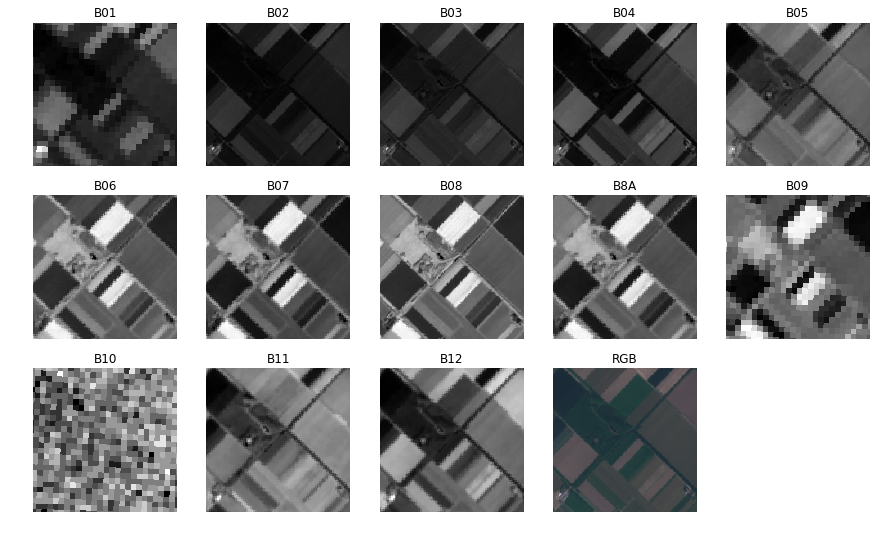

In [1]:
%matplotlib inline 
from src.img_utils import * 
import numpy as np

file="data/ms/train/tulip_03eaae4041bb514267a6af409cc95142_wms_20160511-105343_ALL_BANDS.npy"
with open(file,'rb') as data: 
    image=np.load(data)
    plot_bands(image)


One problem with satellite images is cloud coverage. Depending on the area being studied and the time of the year, a fraction of the images obtained from Sentinel-2 will contain clouds that block visibility. In order not to confuse our model, labeling clouds as tulip fields, we filter out cloudy images. For ease of use, we provide a packaged dataset for training and testing containing only cloudless images.

## Prepare training masks

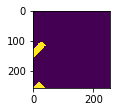

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import PIL
from PIL import Image

fig=plt.figure(figsize=(8, 8))
cols=5
rows=1
ax=[]

file="data/masks/tulip_03eaae4041bb514267a6af409cc95142_geopedia_ttl1904.png"
image= Image.open(file)
ax.append( fig.add_subplot(rows, cols, 1) )
plt.imshow(image)

## Model
The model we will use for segmentation is a variation of U-Net [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597). This CNN was originally designed for biomedical image segmentation, but it also yields state of the art results for other segmentation tasks. The figure below shows a simplified version of the architecture we will work with. This kind of model is well suited for dealing with a structured problem like ours, where a pixel's class does not only depend on its value, but also on its context (the pixels around it).

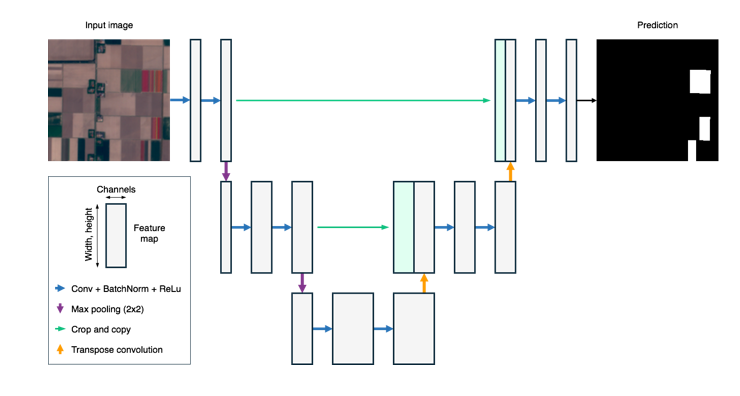

 [U-Net architecture] U-Net architecture. The grey boxes represent feature maps, while the different arrows correspond to operations.

The network is based on an encoder-decoder schema. The contracting path, on the left, progressively increases the number of feature channels to encode the input into feature representations. The expanding path, or decoder, upsamples by applying transpose convolutions while also concatenating data from the contracting path to preserve localization information.

In [4]:
! pygmentize src/unet.py

# U-Net. Taken from:
# https://github.com/chinakook/U-Net

import mxnet.gluon.nn as nn


def conv_block(channels, kernel_size):
    out = nn.HybridSequential()
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return out


def down_block(channels):
    out = nn.HybridSequential()
    out.add(
        conv_block(channels, 3),
        conv_block(channels, 3)
    )
    return out


class UpBlock(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(UpBlock, self).__init__(**kwargs)
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                                            padding=1, use_bias=False)
        self.conv1 = conv_block(channels, 1)
        self.conv3_0 = conv_block(channels, 3)
        if shrink:
            self.conv3_1 = conv_block(int(channels/2), 3)
        else:
            self.conv3_1 = conv_block(chan

## Measuring performance
To measure the performance of our model, we are going to use the most common metric for segmentation tasks: Intersection over Union (IoU). It's a rather intuitive metric: it measures the ratio between a) the 
intersection of the predicted and true regions and b) their union.


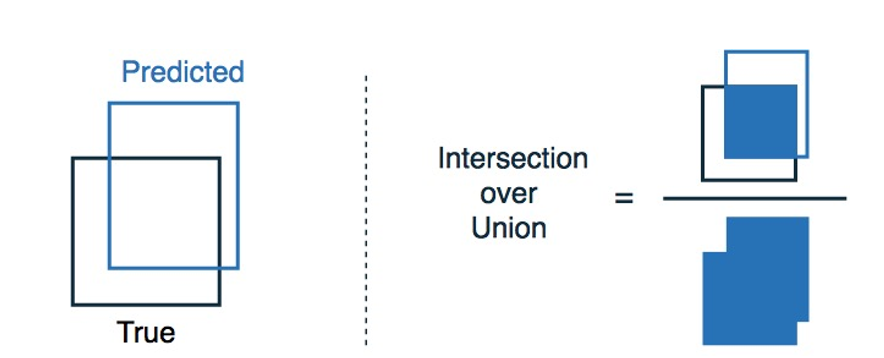

In [135]:
import mxnet.ndarray as nd
import numpy as np
def IOU (inPred,inLabel):
        """
        Implementation of updating metrics
        """
        smooth=1e-7
        axis=[0,1]
        pred=nd.array(inPred)
        pred=pred/nd.max(pred)
        label=nd.array(inLabel)
        label=label/nd.max(label)

        i = nd.sum((pred == 1) * (label == 1),axis=axis)
        u = nd.sum(pred, axis=axis) + nd.sum(label, axis=axis) - i
        iou = (i + smooth) / (u + smooth)
        return (iou.asnumpy())

## Start Training Using Sagemaker
Import libraries used by the model and setup Sagemaker session.

In [3]:
import os
import subprocess
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
s3_bucket_name=''

#Check if GPU is available if running on local notebook instance
instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

role = get_execution_role()

Instance type = local_gpu


Upload data for training

In [3]:
valid_channel = sagemaker_session.upload_data(path='data/ms/test', key_prefix='tulip_field_data/ms_valid_channel')

In [ ]:
train_channel = sagemaker_session.upload_data(path='data/ms/train', key_prefix='tulip_field_data/ms_train_channel')

In [ ]:
masks_channel = sagemaker_session.upload_data(path='data/masks', key_prefix='tulip_field_data/masks_channel')

In [4]:
valid_channel = 's3://sagemaker-us-east-1-348831852500/tulip_field_data/ms_valid_channel'
train_channel = 's3://sagemaker-us-east-1-348831852500/tulip_field_data/ms_train_channel'
masks_channel = 's3://sagemaker-us-east-1-348831852500/tulip_field_data/masks_channel'

valid_channel = 'file://data/ms/test'
train_channel = 'file://data/ms/train'
masks_channel = 'file://data/masks'

In [7]:
unet = MXNet("train.py",
          source_dir='src',
          role=role,
          train_instance_count=1,
          train_instance_type=instance_type,
          #train_instance_type='ml.p3.16xlarge',
          framework_version="1.4.1",
          py_version="py3",
          hyperparameters={'batch-size': 32,
                           'epochs': 5,
                           'gpu-count': 8,
                           'multispectral':"ms"
                           })


In [8]:
data_channels = {'train': train_channel, 'validation': valid_channel, 'masks': masks_channel}

unet.fit(data_channels)

Creating tmpmbgy96ds_algo-1-nu523_1 ... 
Attaching to tmpmbgy96ds_algo-1-nu523_12mdone
algo-1-nu523_1  | 2020-04-01 11:23:07,507 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
algo-1-nu523_1  | 2020-04-01 11:23:07,587 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1-nu523"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":32,"epochs":5,"gpu-count":8,"multispectral":"ms"}', 'SM_USER_ENTRY_POINT': 'train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1-nu523","hosts":["algo-1-nu523"]}', 'SM_INPUT_DATA_CONFIG': '{"masks":{"TrainingInputMode":"File"},"train":{"TrainingInputMode":"File"},"validation":{"TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_CHANNELS': '["masks","train","validation"]', 'SM_CURRENT_HOST': 'algo-1-nu523', 'SM_MODULE_NAME': 'train', 'SM_LOG_LEVEL': '20', 'SM_FRAMEWORK_MODULE': 'sagemaker_mxnet_container.trainin

In [9]:
unet.model_data
#unet.training_job_analytics

's3://sagemaker-us-east-1-348831852500/mxnet-training-2020-04-01-11-22-58-866/model.tar.gz'

## Use previously tarined UNET for predictions
Deploy a Sagemaker Endpoint to serve predictions :
- provide a reference to the trained model
- provide inference script used to manage network load and data adaptation

In [142]:
#model_data=unet.model_data
model_data='s3://sagemaker-us-east-1-348831852500/mxnet-training-2020-04-01-11-22-58-866/model.tar.gz'

In [143]:
from sagemaker.mxnet import MXNetModel
mxnet_model = MXNetModel(model_data=unet.model_data,
                         role=role,
                         entry_point='SM_inference.py',
                         py_version='py3',
                         framework_version='1.4.1',
                         source_dir='src')
predictor = mxnet_model.deploy(instance_type=instance_type,
                               initial_instance_count=1)

Attaching to tmp0amvn6i3_algo-1-brtu9_1
algo-1-brtu9_1  | 2020-04-01 16:45:34,740 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
algo-1-brtu9_1  | MMS Home: /usr/local/lib/python3.6/site-packages
algo-1-brtu9_1  | Current directory: /
algo-1-brtu9_1  | Temp directory: /home/model-server/tmp
algo-1-brtu9_1  | Number of GPUs: 8
algo-1-brtu9_1  | Number of CPUs: 64
algo-1-brtu9_1  | Max heap size: 27305 M
algo-1-brtu9_1  | Python executable: /usr/local/bin/python3.6
algo-1-brtu9_1  | Config file: /etc/sagemaker-mms.properties
algo-1-brtu9_1  | Inference address: http://0.0.0.0:8080
algo-1-brtu9_1  | Management address: http://127.0.0.1:8081
algo-1-brtu9_1  | Model Store: /.sagemaker/mms/models
algo-1-brtu9_1  | Initial Models: ALL
algo-1-brtu9_1  | Log dir: /logs
algo-1-brtu9_1  | Metrics dir: /logs
algo-1-brtu9_1  | Netty threads: 0
algo-1-brtu9_1  | Netty client threads: 0
algo-1-brtu9_1  | Default workers per model: 8
algo-1-brtu9_1  | Blacklist Regex: N/A
algo-1-brtu9_1  | Maximum R

Load images from validation dataset to check model performances

In [144]:
#Load Validation data and related masks
from PIL import Image
import os
import glob
import numpy as np
import ntpath

files = glob.glob(os.path.join('./data/ms/test/', '*' + '.npy'))
images=[]
masks=[]
decode_year={'2016': 'ttl1904', '2017': 'ttl1905'}
i=0

for file in files:
    #Load Image
    #print (file)
    with open(file,'rb') as data: 
        image_data = np.load(data)
        #print (image_data.shape)
        images.append ({'data':image_data})
        
    #Load Label
    filename=ntpath.basename(file)
    parts=filename.split('_')
    year=parts[3][0:4]
    mask_file="./data/masks/{}_{}_geopedia_{}.png".format(parts[0],parts[1],decode_year[year])
    image = Image.open(mask_file)
    image_data = np.asarray(image)
    #print (image_data.shape)
    masks.append ({'data':image_data})
    i=i+1
    
    #More than 5 images at a time could be an issue because of message size limits
    if i>7: 
        break    

(13, 256, 256)
(13, 256, 256)
(13, 256, 256)
(13, 256, 256)
(13, 256, 256)
(13, 256, 256)
(13, 256, 256)
(13, 256, 256)


Prepare serializable message to be sent to Sagemaker endpoint for online prediction and compute the prediction

In [145]:
import gzip
import pickle

dump_value = pickle.dumps(images)
zip_value =  gzip.compress(dump_value)
encodedBytes = base64.b64encode(zip_value)
encodedChars= encodedBytes.decode("utf-8")

#Set image type as multispectral   
body = {'instances': encodedChars, 'type':'ms'}

In [146]:
prediction=predictor.predict (body)

algo-1-brtu9_1  | 2020-04-01 16:45:39,563 [INFO ] W-9004-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Loading /opt/ml/model
algo-1-brtu9_1  | 2020-04-01 16:45:39,563 [INFO ] W-9004-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Loading ALL_BANDS Model
algo-1-brtu9_1  | 2020-04-01 16:45:39,563 [WARN ] W-9004-model-stderr com.amazonaws.ml.mms.wlm.WorkerLifeCycle - /usr/local/lib/python3.6/site-packages/mxnet/gluon/block.py:420: UserWarning: load_params is deprecated. Please use load_parameters.
algo-1-brtu9_1  | 2020-04-01 16:45:39,563 [WARN ] W-9004-model-stderr com.amazonaws.ml.mms.wlm.WorkerLifeCycle -   warnings.warn("load_params is deprecated. Please use load_parameters.")
algo-1-brtu9_1  | 2020-04-01 16:45:39,752 [INFO ] W-9004-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Start Parsing input
algo-1-brtu9_1  | 2020-04-01 16:45:39,758 [INFO ] W-9004-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - End Parsing input
algo-1-brtu9_1  | 2020-04-01 16

Plot predicted value against object mask and IOU Metric for comparison

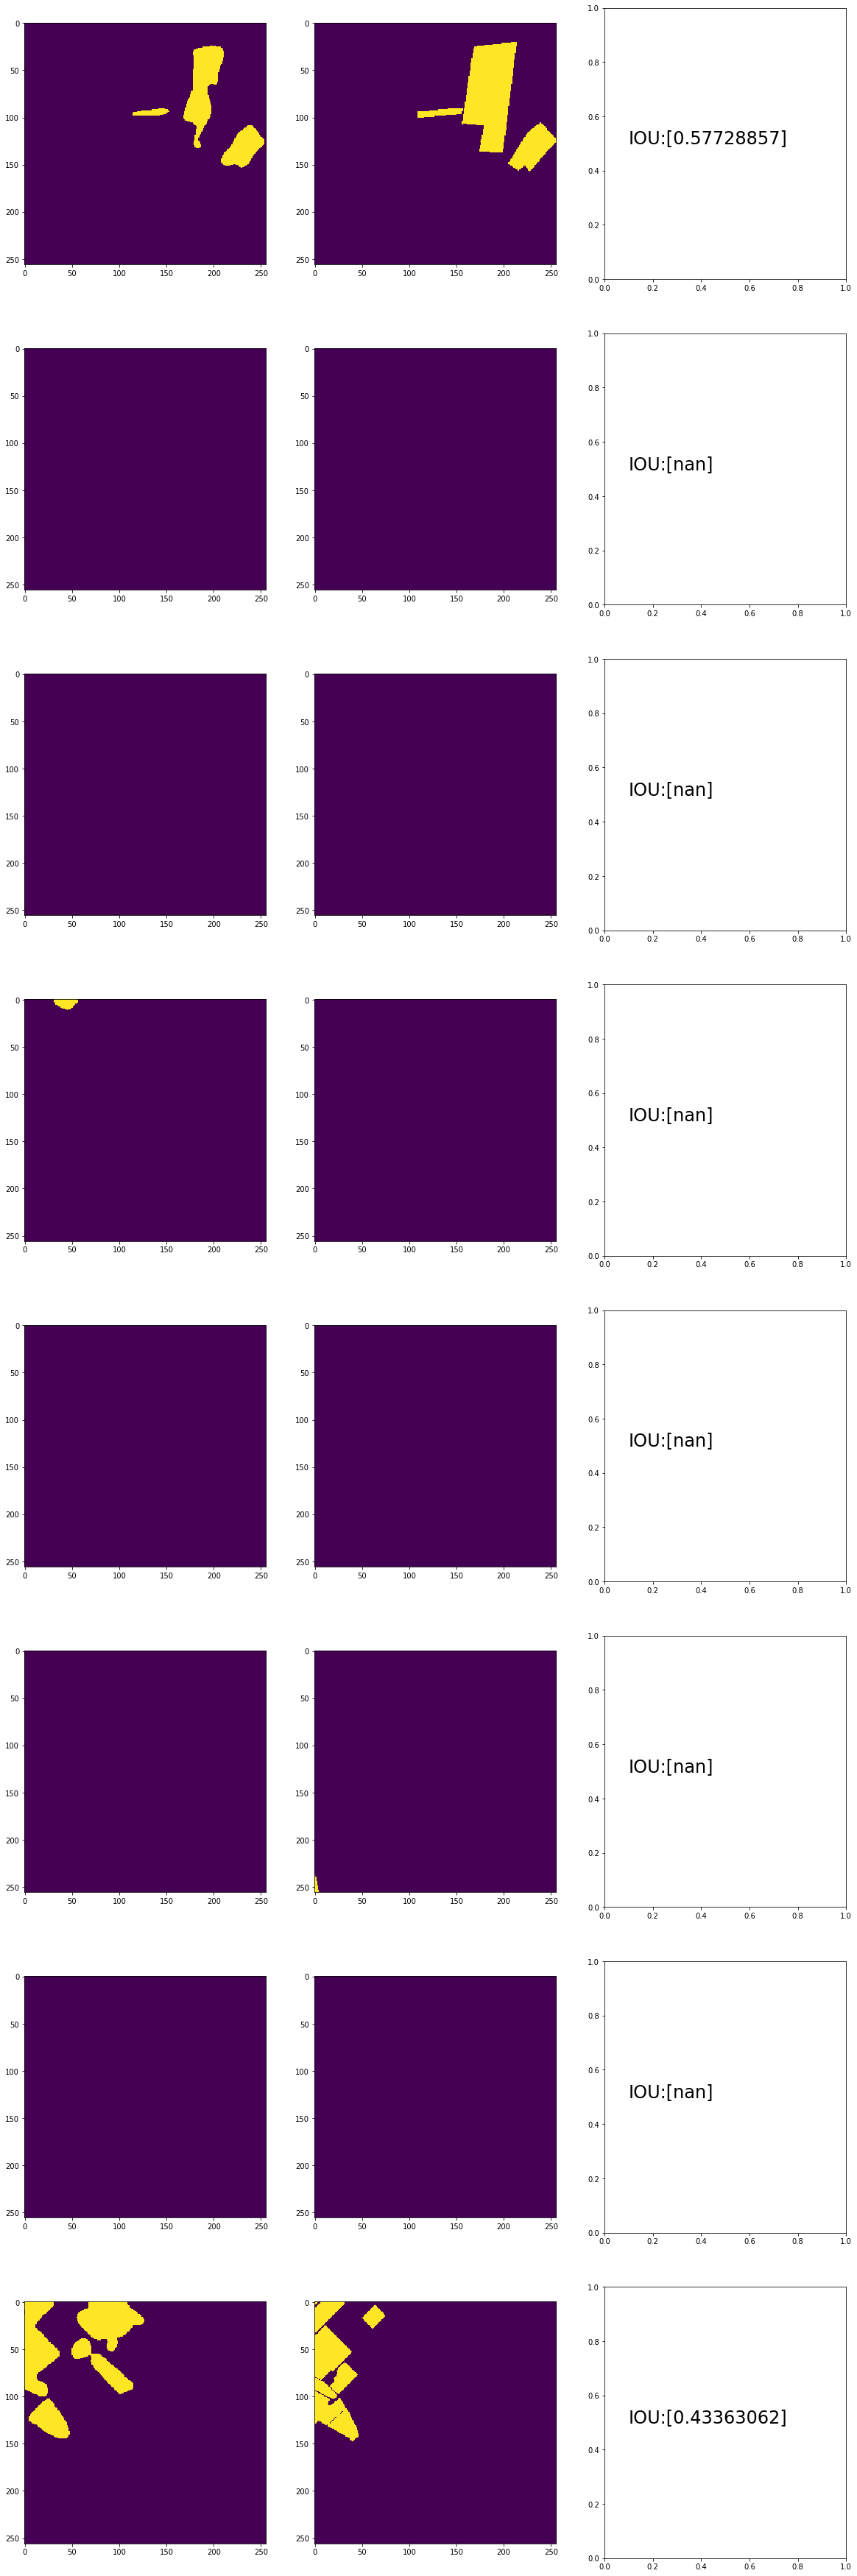

In [147]:
%matplotlib inline 
import matplotlib.pyplot as plt
import PIL
from PIL import Image

def addToPlot (rows,cols,i,image_data):
    img=Image.fromarray(image_data,"L")
    ax.append( fig.add_subplot(rows, cols, i) )
    plt.imshow(img)
 
    
#plt.rcParams['figure.figsize'] = [20, 20]
fig=plt.figure(figsize=(20, 80))
cols=3
rows=10
ax=[]
i=0

for pred,mask in zip (prediction['predictions'],masks ):
    i+=1
    pred_data=np.array(pred['data'], dtype=np.uint8)
    addToPlot (rows,cols,i,pred_data)
    i+=1
    mask_data=np.array(mask['data'], dtype=np.uint8)
    addToPlot (rows,cols,i,mask_data)
    i+=1
    ax.append( fig.add_subplot(rows, cols, i) )
    iou=IOU (pred_data,mask_data)
    plt.text(0.1,0.5,"IOU:{}".format(iou), fontsize=24)


### Remove predictor endpoint
Shut down predictor endpoint in order to avoid unneeded resource usage and related costs

In [148]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
